In [1]:
import glob
import re
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import cv2
import numpy as np
import pandas as pd
import pydicom as dicom
from keras import Model, Input
from keras.src import backend
from keras.src import layers
from keras.src.applications import imagenet_utils
from keras.src.layers import Dense
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.src.applications.densenet import DenseNet201
from keras.src.callbacks import Callback
import gc

In [2]:
# 使用可能なGPUデバイスのリストを取得
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    for device in physical_devices:
        # メモリの動的割り当てを有効にする
        tf.config.experimental.set_memory_growth(device, True)

        # 初期化時に割り当てるメモリ量を制限するための設定
        tf.config.experimental.set_virtual_device_configuration(
            device,
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]  # 1024MB = 1GB
        )

        print(
            '{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
        print('{} memory limit: {} MB'.format(device, 1024))
else:
    print("Not enough GPU hardware devices available")


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory limit: 1024 MB


In [3]:
base_path = './rsna-2024-lumbar-spine-degenerative-classification'
train_png_file_path = f'{base_path}/train_dataset_png'

label_coordinates_df = pd.read_csv(f'{base_path}/train_label_coordinates.csv')
train_series = pd.read_csv(f'{base_path}/train_series_descriptions.csv')
df_train = pd.read_csv(f'{base_path}/train.csv')
df_sub = pd.read_csv(f'{base_path}/sample_submission.csv')
test_series = pd.read_csv(f'{base_path}/test_series_descriptions.csv')

train_dicom = f'{base_path}/train_images'
test_dicom = f'{base_path}/test_images'

model_path = f'model.keras'

In [4]:
# 一つのstudy_idにseries_id が3つ未満のstudy_idを探す
study_id_list = train_series['study_id'].unique()
for study_id in study_id_list:
    series_id_list = train_series[train_series['study_id'] == study_id][
        'series_description'].unique()

    if len(series_id_list) < 3:
        print(f'study_id : {study_id}, series_id : {series_id_list}')

study_id : 2492114990, series_id : ['Axial T2' 'Sagittal T2/STIR']
study_id : 2780132468, series_id : ['Sagittal T2/STIR' 'Axial T2']
study_id : 3008676218, series_id : ['Sagittal T1' 'Axial T2']


In [5]:
# パラメータ
STUDY_NUM = 1975

# 出力のラベル
NORMAL_MILD = 0
MODERATE = 1
SEVERE = 2

# 重症度一覧
SEVERITY_LIST = ['Normal/Mild', 'Moderate', 'Severe']

# dicomデータの種類
SERIES_DESCRIPTION_LIST = train_series['series_description'].unique().tolist()
# 学習用パラメータ
BATCH_SIZE = 16
EPOCHS = 20
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1

# 入出力の形状 (DenseNet201の入力サイズ)
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
INPUT_CHANNEL_DICT = {
    'Sagittal T1': 17,
    'Sagittal T2/STIR': 17,
    'Axial T2': 29
}
IN_CHANS = sum(INPUT_CHANNEL_DICT.values())
IMG_SIZE = [INPUT_WIDTH, INPUT_HEIGHT]

CONDITIONS = [
    'spinal_canal_stenosis',
    'left_neural_foraminal_narrowing',
    'right_neural_foraminal_narrowing',
    'left_subarticular_stenosis',
    'right_subarticular_stenosis'
]

LEVELS = [
    'l1_l2',
    'l2_l3',
    'l3_l4',
    'l4_l5',
    'l5_s1',
]

N_LABELS = 25
N_CLASSES = 3 * N_LABELS

In [6]:
_target_name = "right_subarticular_stenosis_l5_s1"

print(f'train shape : {df_train.shape}')
print(df_train[_target_name].unique())

# それぞれの重症度の数がいくらあるか計算
print(f'Normal/Mild : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0]}')
print(f'Moderate : {df_train[df_train[_target_name] == str("Moderate")].shape[0]}')
print(f'Severe : {df_train[df_train[_target_name] == str("Severe")].shape[0]}')

print(
    f'Normal/Mild ratio : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0] / df_train.shape[0]}')
print(
    f'Moderate ratio : {df_train[df_train[_target_name] == str("Moderate")].shape[0] / df_train.shape[0]}')
print(
    f'Severe ratio : {df_train[df_train[_target_name] == str("Severe")].shape[0] / df_train.shape[0]}')


train shape : (1975, 26)
['Normal/Mild' 'Moderate' 'Severe' nan]
Normal/Mild : 1399
Moderate : 396
Severe : 173
Normal/Mild ratio : 0.7083544303797469
Moderate ratio : 0.20050632911392405
Severe ratio : 0.08759493670886076


In [7]:


def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]


def get_train_label(study_id):
    """
    study_id に対応するラベルを取得 (testはデータがないのでtrainのみ)
    """

    row = df_train[df_train['study_id'] == study_id].to_numpy()[0][1:].tolist()

    row_category = np.zeros((N_LABELS, 3))
    for i in range(N_LABELS):
        if row[i] == 'Normal/Mild':
            row_category[i][0] = 1
        elif row[i] == 'Moderate':
            row_category[i][1] = 1
        elif row[i] == 'Severe':
            row_category[i][2] = 1
    # 1次元配列に変換
    row_category = row_category.flatten()
    return row_category


def get_file_list(study_id, series_desc, file_kind='train'):
    """
    study_id に対応するファイルリストを取得
    """
    dicom_file_list = []
    df = None
    if file_kind == 'train':
        df = train_series
    elif file_kind == 'test':
        df = test_series

    # study_id に対応する series_desc のリストを取得
    series_ids = df[df['study_id'] == study_id]
    series_id = series_ids[series_ids['series_description'] == series_desc]['series_id'].values
    if len(series_id) == 0:
        return dicom_file_list

    series_id = series_id[0]

    target_dicom_dir_path = ''
    if file_kind == 'train':
        target_dicom_dir_path = f'{train_dicom}/{study_id}/{series_id}/'
    elif file_kind == 'test':
        target_dicom_dir_path = f'{test_dicom}/{study_id}/{series_id}/'
    dicom_file_list = glob(target_dicom_dir_path + '/*.dcm')
    # ファイル名が数字になっているのでソート
    dicom_file_list = sorted(dicom_file_list, key=natural_keys)

    # series_desc にt対応するファイルリストを取得
    return dicom_file_list


def load_dicom_img(dicom_filepath):
    """
    dicomファイルを読み込む
    """
    dicom_data = dicom.read_file(dicom_filepath).pixel_array

    # 0-1に正規化
    dicom_data = dicom_data / np.max(dicom_data)

    # 0~255に変換
    dicom_data = dicom_data * 255

    # 512x512にリサイズ
    dicom_data = cv2.resize(dicom_data, (INPUT_WIDTH, INPUT_HEIGHT))

    # uint8 に変換
    dicom_data = dicom_data.astype(np.uint8)

    return dicom_data


def get_dicom_input_data(study_id, file_kind='train'):
    """
    study_id に対応するdicomデータを取得
    """

    input_dicom = np.zeros((INPUT_WIDTH, INPUT_HEIGHT, IN_CHANS))
    # Sagittal T1
    sagittal_t1_dicom_list = get_file_list(study_id, 'Sagittal T1', file_kind)
    if len(sagittal_t1_dicom_list) > 0:
        for i in range(INPUT_CHANNEL_DICT['Sagittal T1']):
            if i < len(sagittal_t1_dicom_list):
                dicom_data = load_dicom_img(sagittal_t1_dicom_list[i])
                input_dicom[:, :, i] = dicom_data

    # Sagittal T2/STIR
    sagittal_t2_dicom_list = get_file_list(study_id, 'Sagittal T2/STIR', file_kind)
    if len(sagittal_t2_dicom_list) > 0:
        for i in range(INPUT_CHANNEL_DICT['Sagittal T2/STIR']):
            if i < len(sagittal_t2_dicom_list):
                dicom_data = load_dicom_img(sagittal_t2_dicom_list[i])
                input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1']] = dicom_data

    # Axial T2
    axial_t2_dicom_list = get_file_list(study_id, 'Axial T2', file_kind)
    if len(axial_t2_dicom_list) > 0:
        for i in range(INPUT_CHANNEL_DICT['Axial T2']):
            if i < len(axial_t2_dicom_list):
                dicom_data = load_dicom_img(axial_t2_dicom_list[i])
                input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1'] + INPUT_CHANNEL_DICT[
                    'Sagittal T2/STIR']] = dicom_data

    # uint8 に変換
    input_dicom = input_dicom.astype(np.int8)
    return input_dicom


def get_dicom_and_label(study_id, file_kind):
    x_data = get_dicom_input_data(study_id, file_kind)
    y_data = get_train_label(study_id)
    return x_data, y_data


def generator(batch_size, study_ids, file_kind='train', is_augmentation=False, is_shuffle=False):
    """
    データセットの読み込み関数
    """
    while True:
        if is_shuffle:
            np.random.shuffle(study_ids)

        for start in range(0, len(study_ids), batch_size):
            gc.collect()

            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(study_ids))
            ids_train_batch = study_ids[start:end]

            with ThreadPoolExecutor() as executor:
                results = list(
                    executor.map(lambda sid: get_dicom_and_label(sid, file_kind), ids_train_batch))

            for x_data, y_data in results:
                if is_augmentation:
                    # 画像データにノイズを加える
                    x_data = x_data + np.random.normal(0, 0.1, x_data.shape)

                x_batch.append(x_data)
                y_batch.append(y_data)

            yield np.array(x_batch), np.array(y_batch)


# 学習用データの study_id を取得
def get_train_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    train_study_ids = _study_ids[:int(len(_study_ids) * 0.8)]
    return train_study_ids


# 検証用データの study_id を取得
def get_valid_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    valid_study_ids = _study_ids[int(len(_study_ids) * 0.8):int(len(_study_ids) * 0.9)]
    return valid_study_ids


# テスト用データの study_id を取得 (実際のテストデータではなく, 学習データの一部をテストデータとして使用)
def get_test_study_id_array():
    _study_ids = train_series['study_id'].unique()
    # 0.8 で分割
    test_study_ids = _study_ids[int(len(_study_ids) * 0.9):]
    return test_study_ids


def generator_for_test(batch_size, study_ids):
    """
    test_seriesからテスト用のデータセット作成
    kaggle で提出時に呼び出される
    :param batch_size: 
    :param study_ids: 
    :return: 
    """
    for start in range(0, len(study_ids), batch_size):
        x_batch = []
        end = min(start + batch_size, len(study_ids))
        ids_train_batch = study_ids[start:end]

        results = []
        for sid in ids_train_batch:
            results.append(get_dicom_input_data(sid, 'train'))
        for x_data in results:
            x_batch.append(x_data)

        yield np.array(x_batch), ids_train_batch

In [8]:
# 2492114990
for desc in SERIES_DESCRIPTION_LIST:
    dicom_image_list = get_file_list(2492114990, desc)
    print(f'{desc} : {len(dicom_image_list)}')

Sagittal T2/STIR : 18
Sagittal T1 : 0
Axial T2 : 53


In [9]:
# study_id のリストを作成
train_study_ids = get_train_study_id_array()
print(len(train_study_ids))
valid_study_ids = get_valid_study_id_array()
print(len(valid_study_ids))
test_study_ids = get_test_study_id_array()
print(len(test_study_ids))

1580
197
198


In [10]:
get_train_label(4003253)

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0.])

画像サイズ[GB] : 0.0029439926147460938
データセット全体のデータ数は 5.814385414123535


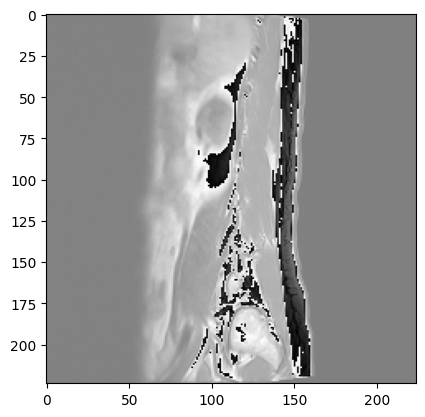

In [11]:
dicom_image_list = get_file_list(4003253, 'Sagittal T1')

input_image = get_dicom_input_data(4003253)
plt.imshow(input_image[:, :, 0], cmap='gray')
input_data_gb = input_image.nbytes / 1024 / 1024 / 1024
print(f"画像サイズ[GB] : {input_data_gb}")
print(f'データセット全体のデータ数は {input_data_gb * STUDY_NUM}')

In [12]:



def total_acc(y_true, y_pred):
    pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float64)
    flag = tf.dtypes.cast(tf.math.equal(y_true, pred), tf.float64)
    return tf.reduce_prod(flag, axis=-1)


def binary_acc(y_true, y_pred):
    pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float64)
    flag = tf.dtypes.cast(tf.math.equal(y_true, pred), tf.float64)
    return tf.reduce_mean(flag, axis=-1)


def create_model():
    # カスタム入力層
    input_shape = (INPUT_WIDTH, INPUT_HEIGHT, IN_CHANS)
    inputs = Input(shape=input_shape)

    # channel を 3 に変換
    x = layers.Conv2D(3, (1, 1), padding='same')(inputs)

    # DenseNet201ベースモデル（トップ層なし）
    base_model = DenseNet201(
        include_top=True,
        weights=None,
        input_tensor=x,
        input_shape=(INPUT_WIDTH, INPUT_HEIGHT, 3),
        pooling=None,
        classes=75,
        classifier_activation='sigmoid'
    )

    # モデルの作成
    model = Model(inputs=inputs, outputs=base_model.output)

    # モデルのコンパイル
    model.compile(optimizer='adam',
                  loss="binary_crossentropy",
                  metrics=[binary_acc, total_acc])

    return model


model = create_model()

2024-06-29 17:58:13.387460: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-29 17:58:13.387483: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-29 17:58:13.387490: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-29 17:58:13.387511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-29 17:58:13.387528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
class CustomCheckpoint(Callback):
    def __init__(self, filepath):
        super(CustomCheckpoint, self).__init__()
        self.filepath = filepath
        self.best_val_accuracy = -1

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_binary_acc = logs.get('val_binary_acc')

        if val_binary_acc is not None and val_binary_acc > self.best_val_accuracy and val_binary_acc > 0.4:
            self.best_val_accuracy = val_binary_acc
            filepath = f'{self.filepath}_epoch{epoch + 1}_val_acc{val_binary_acc:.4f}.keras'
            self.model.save(filepath, overwrite=True)
            print(f'Saved model to {filepath} with validation accuracy: {val_binary_acc:.4f}')
        else:
            # 10 epoch ごとにモデルを保存
            if (epoch + 1) % 10 == 0:
                filepath = f'{self.filepath}_epoch{epoch + 1}_val_acc{val_binary_acc:.4f}.keras'
                self.model.save(filepath, overwrite=True)
                print(f'Saved model to {filepath} with validation accuracy: {val_binary_acc:.4f}')


# カスタムチェックポイントのコールバックを作成
custom_checkpoint = CustomCheckpoint(filepath='model_dense')

In [ ]:
# モデルの学習
history = model.fit(
    generator(BATCH_SIZE, train_study_ids, is_augmentation=True, is_shuffle=True),
    steps_per_epoch=len(train_study_ids) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=generator(BATCH_SIZE, valid_study_ids),
    validation_steps=len(valid_study_ids) // BATCH_SIZE,
    callbacks=[custom_checkpoint]
)

model.save(model_path)

In [14]:
# モデルの読み込み
loaded_model = tf.keras.models.load_model(model_path, custom_objects={
    'binary_acc': binary_acc,
    'total_acc': total_acc
})

In [ ]:
# モデルの評価
score = loaded_model.evaluate(generator(1, test_study_ids), steps=len(test_study_ids) // BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [15]:
# test_dataset_ids = test_series['study_id'].unique()
test_dataset_ids = train_series['study_id'].unique()

row_names = []
y_preds = []
submission_labels = ['normal_mild', 'moderate', 'severe']
# test_study_ids を元に予測
count = 0
for x, sids in generator_for_test(BATCH_SIZE, test_dataset_ids):
    count += BATCH_SIZE
    # 残りのデータ数
    print(f'remaining data : {len(test_dataset_ids) - count}')
    
    y = loaded_model.predict(x)
    for i in range(min(BATCH_SIZE, y.shape[0])):
        y_pred = y[i]

        # 予測結果を (25, 3) に変換
        y_pred = y_pred.reshape((25, 3))

        # 予測結果をsoftmax関数で確率に変換
        y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1).reshape(-1, 1)

        # 小数点第3位まで表示
        y_pred = np.round(y_pred, 3)

        y_preds.append(y_pred)

        # row の名前を作成
        for cond in CONDITIONS:
            for level in LEVELS:
                row_names.append(f'{sids[i]}_{cond}_{level}')
y_preds = np.concatenate(y_preds, axis=0)

remaining data : 1959


2024-06-29 17:58:26.286033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
remaining data : 1943
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
remaining data : 1927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
remaining data : 1911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
remaining data : 1895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
remaining data : 1879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
remaining data : 1863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
remaining data : 1847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
remaining data : 1831
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
remaining data : 1815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
remaining data : 1799
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
remaining data : 1783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
remaining data : 1767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
remaining data : 1751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
remaining data : 1735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
remaining data : 1719
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
remaining data : 1703
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
print(len(submission_labels))
print(y_preds.shape)
print(len(row_names))
submission_labels

3
(49375, 3)
49375


['normal_mild', 'moderate', 'severe']

In [17]:
sub = pd.DataFrame()
sub['row_id'] = row_names
sub[submission_labels] = y_preds

In [18]:
sub.to_csv('submission.csv', index=False)

In [19]:
sub

,row_id,normal_mild,moderate,severe
0,4003253_spinal_canal_stenosis_l1_l2,0.567,0.218,0.215
1,4003253_spinal_canal_stenosis_l2_l3,0.555,0.225,0.220
2,4003253_spinal_canal_stenosis_l3_l4,0.514,0.254,0.232
3,4003253_spinal_canal_stenosis_l4_l5,0.465,0.277,0.258
4,4003253_spinal_canal_stenosis_l5_s1,0.557,0.224,0.219
...,...,...,...,...
49370,4290709089_right_subarticular_stenosis_l1_l2,0.569,0.216,0.215
49371,4290709089_right_subarticular_stenosis_l2_l3,0.566,0.220,0.214
49372,4290709089_right_subarticular_stenosis_l3_l4,0.543,0.238,0.219
49373,4290709089_right_subarticular_stenosis_l4_l5,0.449,0.304,0.247
